In [385]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm
import time
import re
from collections import Counter
import math

# from TransformerModel import *

import importlib, TransformerModel
importlib.reload(TransformerModel)
from TransformerModel import TinyGPT

# Data Collection 

In [401]:
### ~~~~~~~~~~~~~~~~~~~~~ ###
###    token definition   ###
### ~~~~~~~~~~~~~~~~~~~~~ ###
paths = ["data/PrideAndPrejudice.txt", "data/Emma.txt", "data/SenseAndSensibility.txt"]
text = "\n".join(open(p, "r", encoding="utf-8", errors="ignore").read().lower() for p in paths)

# simple tokenizer: words or single punctuation marks
tokens = re.findall(r"[a-z]+|[0-9]+|[^\s\w]", text)
print("num tokens:", len(tokens), "unique:", len(set(tokens)))

num tokens: 314744 unique: 9376


In [405]:
### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###
###    vocab definition, encoding   ###
### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###
vocab_size = 10_000
special = ["<pad>", "<unk>"]  # pad will make each token same length, unk is reserved for words not in vocab

counts = Counter(tokens)
most_common = [w for (w, _) in counts.most_common(vocab_size - len(special))]
vocab = special + most_common

# string-to-index,  index-to-string
stoi = {w:i for i,w in enumerate(vocab)}
itos = {i:w for w,i in stoi.items()}

# ids = entire book written in integers
ids = torch.tensor([stoi.get(tok, stoi["<unk>"]) for tok in tokens], dtype=torch.long)
print("ids shape:", ids.shape, "UNK rate:", (ids == stoi["<unk>"]).float().mean().item())
print(ids[:10])

ids shape: torch.Size([314744]) UNK rate: 0.0
tensor([4073,    4,  145,  137,  771,    6,  404,    7,  874,   46])


In [388]:
### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###
###    Sentence / Phrase Extractor   ###
### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###
# batch_size = number of excerpts
# block_size = length of each excerpt
def get_batch(data_ids, batch_size=32, block_size=128, device="cpu"):
    # random starting indices
    ix = torch.randint(0, len(data_ids) - block_size - 1, (batch_size,))
    x = torch.stack([data_ids[i:i+block_size] for i in ix]).to(device)  ## random sentence / phrase
    y = torch.stack([data_ids[i+1:i+block_size+1] for i in ix]).to(device) ## shifted sentence / phrase
    return x, y

# quick sanity check
x, y = get_batch(ids, batch_size=4, block_size=8)
print(x)
print(x[0].tolist())
print(y[0].tolist())
print([itos[i] for i in x[0].tolist()])
print([itos[i] for i in y[0].tolist()])


tensor([[   5, 1493,   37,    3,   30,   29,   11,   70],
        [ 974,    6,  446,   79,   83,    8,   97,  622],
        [   4, 3388,    6,   25, 2260, 2965,    3,   27],
        [  74,   78,   12,   33,  230,  331,    5,  168]])
[5, 1493, 37, 3, 30, 29, 11, 70]
[1493, 37, 3, 30, 29, 11, 70, 19]
['to', 'introduce', 'him', '.', '”', '“', 'i', 'do']
['introduce', 'him', '.', '”', '“', 'i', 'do', 'not']


# Model Definition & Training

In [389]:
##  See TransformerModel.py for  
##    -- CausalSelfAttention
##    -- Block = LayerNorm + SelfAtt + LayerNorm + MLP 
##    -- TinyGPT 

In [390]:
B, T, d_model, n_heads = 1, 5, 64, 4
x = torch.randn(B, T, d_model)

attn = CausalSelfAttention(d_model=d_model, n_heads=n_heads, block_size=128);
y1 = attn(x)

In [408]:
### ~~~~~~~~~~~~~~~~~~~~ ###
###    Model Definition  ###
### ~~~~~~~~~~~~~~~~~~~~ ###
device = "cpu"
# hyperparams
block_size = 128  ## excerpt size (few sentences)
batch_size = 32   ## number of excerpts

model = TinyGPT(vocab_size=len(vocab), block_size=block_size, 
                d_model=256, n_blocks=4, n_heads=4, d_ff=1024).to(device)

n_params = sum(p.numel() for p in model.parameters())
n_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("total params:", n_params)
print("trainable params:", n_trainable)

# optimizer
lr = 3e-4
opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.1)

total params: 5588992
trainable params: 5588992


In [409]:
### ~~~~~~~~~~~~~~~ ###
###    Train Model  ###
### ~~~~~~~~~~~~~~~ ###
def decode(token_ids):
    return " ".join(itos[i] for i in token_ids)


steps = 50_000; 
losses = []; 
for step in range(1, steps+1):
    ## Get a random excerpt (x) and excerpt+1 (y) 
    x, y = get_batch(ids, batch_size=batch_size, block_size=block_size, device=device)  # (B,T)
    logits = model(x)  # (B,T,V)
    loss = F.cross_entropy(logits.view(-1, len(vocab)), y.view(-1))

    opt.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    opt.step()
    if step % 200 == 0:
        losses.append(loss.item())
        print("step", step, "loss", float(loss))
        # quick greedy sample from last position
        ctx, _ = get_batch(ids, batch_size=1, block_size=15, device=device)
        with torch.no_grad():
            out = ctx.clone()
            for _ in range(15):
                logits = model(out[:, -block_size:])
                next_id = logits[:, -1, :].argmax(dim=-1, keepdim=True)  # choose most likely next token
                out = torch.cat([out, next_id], dim=1)
        prompt_ids = out[0, :15].tolist()
        gen_ids    = out[0, 15:30].tolist()
        print("     Real Excerpt:\n", decode(prompt_ids))
        print("Generated Excerpt:\n", decode(gen_ids))
        print()

step 200 loss 9.99152946472168
     Real Excerpt:
 one who knew her , was to her comprehension impossible . edward ferrars was not
Generated Excerpt:
 , i have been , and the , and the , and the , and

step 400 loss 6.68647575378418
     Real Excerpt:
 , miss eliza , are not the - - - - shire militia removed from
Generated Excerpt:
 the same , and the little . i have been , and the whole ,

step 600 loss 5.936778545379639
     Real Excerpt:
 her concern thereupon , he assured her , with much earnest gravity , that it
Generated Excerpt:
 was , and her sister , and , and her sister , and the world

step 800 loss 5.533998012542725
     Real Excerpt:
 think of my husband ? is not he a charming man ? i am sure
Generated Excerpt:
 , and i am , i am , i am , i have been a

step 1000 loss 5.476926803588867
     Real Excerpt:
 ferrars . " " i have burnt all your letters , and will return your
Generated Excerpt:
 sister , " " " " " " " " said elinor , " "

step 1200 loss 5.379947185516357
     R

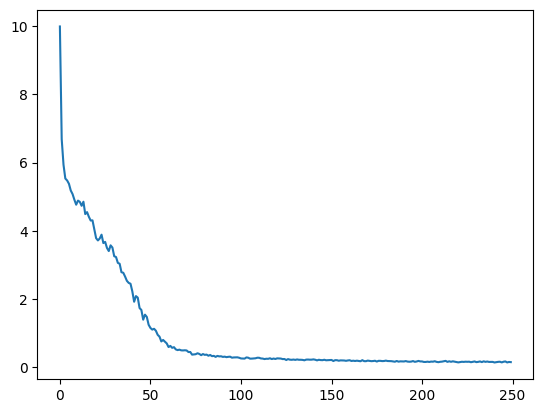

In [421]:
plt.plot(losses)

In [332]:
print(d_model, block_size, n_blocks, n_heads, len(vocab), step)

64 128 4 4 9378 25000


In [414]:
## Save model to reload later
model_5p6Mparams = {
    "model_state": model.state_dict(),
    "opt_state": opt.state_dict(),
    "step": 50_000,
    "config": dict(
        vocab_size=len(vocab),
        block_size=block_size,
        d_model=256,
        n_blocks=n_blocks,
        n_heads=n_heads,
        d_ff=1024,
    ),
}
torch.save(model_5p6Mparams, "miniGPT_5p6Mparams.pt")

# Attention Heatmap

In [364]:
# Take one excerpt, idx 
model.eval()
idx, _ = get_batch(ids, batch_size=1, block_size=128) 
with torch.no_grad():
    _, attn_maps = model(idx, return_attn=True)

# Define #batches (1), token length (T), #blocks, and #heads 
B, T = idx.shape
n_blocks = len(attn_maps)
n_heads =  attn_maps[0].shape[1]
print("TEXT:\n", " ".join(itos[i] for i in idx[0].tolist()))
print(n_blocks, n_heads, np.shape(attn_maps))

TEXT:
 a united states copyright in these works , so the foundation ( and you ! ) can copy and distribute it in the united states without permission and without paying copyright royalties . special rules , set forth in the general terms of use part of this license , apply to copying and distributing project gutenberg ™ electronic works to protect the project gutenberg ™ concept and trademark . project gutenberg is a registered trademark , and may not be used if you charge for an ebook , except by following the terms of the trademark license , including paying royalties for use of the project gutenberg trademark . if you do not charge anything for copies of this ebook , complying with the trademark license is very
4 4 (4, 1, 4, 128, 128)


In [363]:
# Try to make a repeated random sequence ... 
L = 16
base, _ = get_batch(ids, batch_size=1, block_size=L)
idx = torch.cat([base, base, base, base], dim=1)
with torch.no_grad():
    _, attn_maps = model(idx, return_attn=True)

# Define #batches (1), token length (T), #blocks, and #heads 
B, T = idx.shape
n_blocks = len(attn_maps)
n_heads =  attn_maps[0].shape[1]
print("TEXT:\n", " ".join(itos[i] for i in idx[0].tolist()))

TEXT:
 , and she repeated the word " selfish ? " in a tone that implied , , and she repeated the word " selfish ? " in a tone that implied , , and she repeated the word " selfish ? " in a tone that implied , , and she repeated the word " selfish ? " in a tone that implied ,


In [415]:
# Repeat vs control, then you'll plot Δ = (repeat - control) later
L = 16
torch.manual_seed(0)
np.random.seed(0)
base, _  = get_batch(ids, batch_size=1000, block_size=L)
rand2, _ = get_batch(ids, batch_size=1000, block_size=L)
rand3, _ = get_batch(ids, batch_size=1000, block_size=L)
rand4, _ = get_batch(ids, batch_size=1000, block_size=L)

idx_rep = torch.cat([base, base, base, base], dim=1)
idx_ctl = torch.cat([base, rand2, rand3, rand4], dim=1)
# idx_ctl = torch.cat([rand1], dim=1)

with torch.no_grad():
    _, attn_rep = model(idx_rep, return_attn=True)
    _, attn_ctl = model(idx_ctl, return_attn=True)

B, T = idx_rep.shape
n_blocks = len(attn_rep)
n_heads  = attn_rep[0].shape[1]
print("TEXT (repeat):\n", " ".join(itos[i] for i in idx_rep[0].tolist()))
print("TEXT (control):\n", " ".join(itos[i] for i in idx_ctl[0].tolist()))


TEXT (repeat):
 so little to be trusted . ” “ you must not blame my aunt . lydia so little to be trusted . ” “ you must not blame my aunt . lydia so little to be trusted . ” “ you must not blame my aunt . lydia so little to be trusted . ” “ you must not blame my aunt . lydia
TEXT (control):
 so little to be trusted . ” “ you must not blame my aunt . lydia rest of the company soon dropt in . " i am afraid , miss marianne , ; there is always so much comfort , so much elegance about them . and i . he drew a chair near her . lady catherine listened to half a song ,


{-3: 0.011139273, -2: 0.012984422, -1: 0.014986575, 0: 0.009536674, 1: 0.022954535, 2: 0.023372887, 3: 0.025425503}
Δ on copy diag: -0.0102999555
Δ on induction diag: 0.0046767676
{-3: 0.010708413, -2: 0.01272099, -1: 0.014101441, 0: 0.009734227, 1: 0.02399564, 2: 0.022937384, 3: 0.026019285}
Δ on copy diag: -0.010001499
Δ on induction diag: 0.005100189
{-3: 0.0122001935, -2: 0.013959696, -1: 0.015230263, 0: 0.011324245, 1: 0.024568541, 2: 0.02540308, 3: 0.027149495}
Δ on copy diag: -0.010249103
Δ on induction diag: 0.0039324546
{-3: 0.011321228, -2: 0.012681997, -1: 0.014609603, 0: 0.010039628, 1: 0.029859355, 2: 0.026119808, 3: 0.027174048}
Δ on copy diag: -0.011488144
Δ on induction diag: 0.008869134


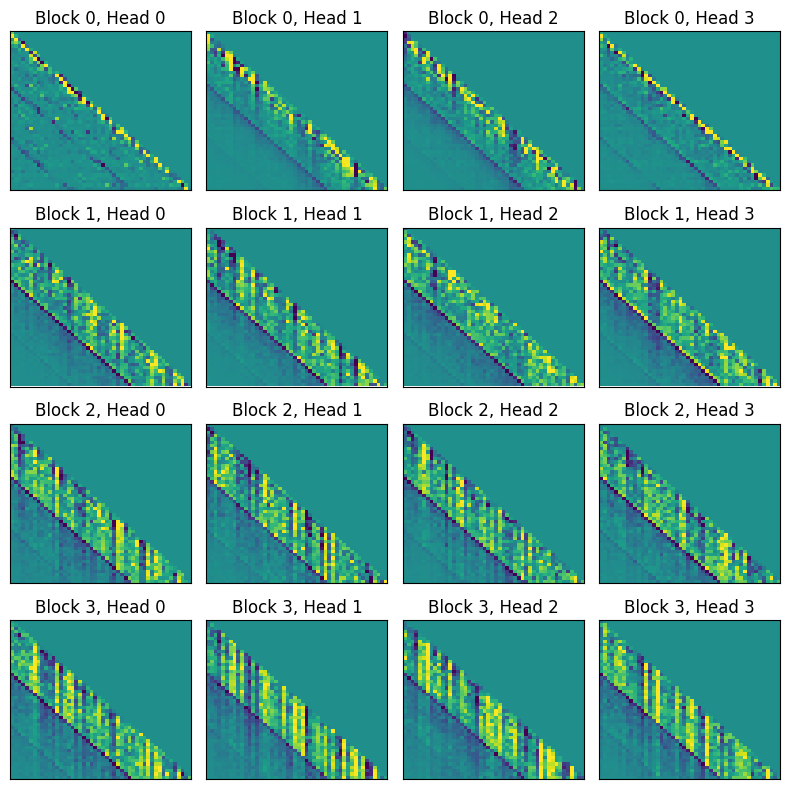

TEXT:
 a united states copyright in these works , so the foundation ( and you ! ) can copy and distribute it in the united states without permission and without paying copyright royalties . special rules , set forth in the general terms of use part of this license , apply to copying and distributing project gutenberg ™ electronic works to protect the project gutenberg ™ concept and trademark . project gutenberg is a registered trademark , and may not be used if you charge for an ebook , except by following the terms of the trademark license , including paying royalties for use of the project gutenberg trademark . if you do not charge anything for copies of this ebook , complying with the trademark license is very


In [416]:
## Plot Heatmap
def diag_means(M, max_off=5):
    out = {}
    for off in range(-max_off, max_off+1):
        d = np.diagonal(M, offset=off)
        if len(d): out[off] = d.mean()
    return out
fig, axes = plt.subplots(n_blocks, n_heads, figsize=(2*n_heads, 2*n_blocks))
for b in range(n_blocks): 
    # A = attn_maps[b].mean(dim=0).detach().cpu().numpy() # take the first batch B ( shape = (n,T,T) ) 
    A_rep = attn_rep[b].mean(dim=0).detach().cpu().numpy()   # (H,T,T)
    A_ctl = attn_ctl[b].mean(dim=0).detach().cpu().numpy()
    A = A_rep - A_ctl     
    for h in range(n_heads):
        L = 16; k = 1;
        M = A[h, k*L:(k+1)*L, (k-1)*L:k*L]
        ####################################
        Mraw = attn_rep[b].mean(0)[h, k*L:(k+1)*L, (k-1)*L:k*L].cpu().numpy()
        if b==1: print(diag_means(Mraw, max_off=3))   # induction head should peak at off=+1

        if b==1: print("Δ on copy diag:",     np.diagonal(A[h], offset=-L).mean())
        if b==1: print("Δ on induction diag:",np.diagonal(A[h], offset=-(L-1)).mean())
        ########################################
        ax = axes[b, h] 
        # M = M / (M.sum(axis=1, keepdims=True) + 1e-9)
        # M = M - M.mean(axis=1, keepdims=True)
        # M = (A_rep - A_ctl)[h, k*L:(k+1)*L, (k-1)*L:k*L]
        # v = np.max(np.abs(M))
        v = np.percentile(np.abs(A[h]), 99) 
        ax.imshow(A[h][L:4*L, L:4*L],  cmap="viridis", vmin=-v, vmax=v, aspect="auto", origin="upper")
        # ax.imshow(M,  cmap="viridis", vmin=-v, vmax=v, aspect="auto", origin="upper")
        ax.set_title(f"Block {b}, Head {h}")
        ax.set_xticks([]); ax.set_yticks([])
        d0  = np.diagonal(M,  0).mean()   # copy
        dm1 = np.diagonal(M, -1).mean()   # induction (t -> t-1)
        dp1 = np.diagonal(M, +1).mean()   # anti-induction (t -> t+1) 
        # print("copy", d0, "ind(-1)", dm1, "ind(+1)", dp1, "best", max(dm1,dp1)-d0)
plt.tight_layout()
plt.show()
# print the actual tokens / text for the prompt you're plotting
print("TEXT:\n", " ".join(itos[i] for i in idx[0].tolist()))